<a href="https://colab.research.google.com/github/SkyoKen/dogsVScats/blob/master/dogsVScats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.データセットのダウンロード（kaggleから）

In [4]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!pip install kaggle --upgrade

!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [5]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 538M/544M [00:04<00:00, 190MB/s]
100% 544M/544M [00:04<00:00, 125MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 128MB/s]
 99% 269M/271M [00:01<00:00, 204MB/s]
100% 271M/271M [00:01<00:00, 187MB/s]


In [6]:
#解凍
!unzip test.zip
!unzip train.zip

Archive:  test.zip
   creating: test/
  inflating: test/1.jpg              
  inflating: test/10.jpg             
  inflating: test/100.jpg            
  inflating: test/1000.jpg           
  inflating: test/10000.jpg          
  inflating: test/10001.jpg          
  inflating: test/10002.jpg          
  inflating: test/10003.jpg          
  inflating: test/10004.jpg          
  inflating: test/10005.jpg          
  inflating: test/10006.jpg          
  inflating: test/10007.jpg          
  inflating: test/10008.jpg          
  inflating: test/10009.jpg          
  inflating: test/1001.jpg           
  inflating: test/10010.jpg          
  inflating: test/10011.jpg          
  inflating: test/10012.jpg          
  inflating: test/10013.jpg          
  inflating: test/10014.jpg          
  inflating: test/10015.jpg          
  inflating: test/10016.jpg          
  inflating: test/10017.jpg          
  inflating: test/10018.jpg          
  inflating: test/10019.jpg          
  inflating:

# 2.ライブラリのインポート

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

#install TensorFlow
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

# 3.画像データの処理
データセット画像は画像サイズが違うので、リサイズする必要がある。

In [9]:
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'

# 64x64
ROWS = 64
COLS = 64
CHANNELS = 3

#选择文件
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # 全选
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

random.shuffle(train_images)  #打乱

#读取图像并统一大小
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

#处理图像+进度条
def prep_data(images):
    count = len(images)
    data = np.ndarray((count,  ROWS, COLS,CHANNELS), dtype=np.uint8)
    for i, image_file in enumerate(images):
        data[i] = read_image(image_file)
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data
print("-----Train Data-----")
train = prep_data(train_images)
print("-----Test  Data-----")
test = prep_data(test_images)
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))


-----Train Data-----
Processed 0 of 25000
Processed 250 of 25000
Processed 500 of 25000
Processed 750 of 25000
Processed 1000 of 25000
Processed 1250 of 25000
Processed 1500 of 25000
Processed 1750 of 25000
Processed 2000 of 25000
Processed 2250 of 25000
Processed 2500 of 25000
Processed 2750 of 25000
Processed 3000 of 25000
Processed 3250 of 25000
Processed 3500 of 25000
Processed 3750 of 25000
Processed 4000 of 25000
Processed 4250 of 25000
Processed 4500 of 25000
Processed 4750 of 25000
Processed 5000 of 25000
Processed 5250 of 25000
Processed 5500 of 25000
Processed 5750 of 25000
Processed 6000 of 25000
Processed 6250 of 25000
Processed 6500 of 25000
Processed 6750 of 25000
Processed 7000 of 25000
Processed 7250 of 25000
Processed 7500 of 25000
Processed 7750 of 25000
Processed 8000 of 25000
Processed 8250 of 25000
Processed 8500 of 25000
Processed 8750 of 25000
Processed 9000 of 25000
Processed 9250 of 25000
Processed 9500 of 25000
Processed 9750 of 25000
Processed 10000 of 25000


Text(0.5, 1.0, 'Cats and Dogs')

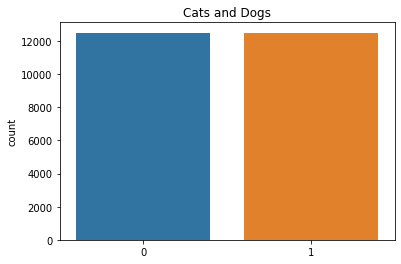

In [121]:
#将训练数据中的猫狗图像分类
count = len(train_images)
labels = np.ndarray(count, dtype=np.uint8)
for i in range(count):
  if 'dog.' in train_images[i]:
    labels[i] = 1
  else:
    labels[i] = 0
sns.countplot(labels)
plt.title('Cats and Dogs')

# 4.トレーニングとテストデータに分割
トレーニング用とテスト用にデータを8:2の割合で分割する。

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(train,labels, test_size=0.2, random_state=1)

# 5.モデルA
TensorFlow公式Image classificationに用いたモデル

In [0]:
epochs=50
batch_size=16
optimizer = RMSprop(lr=5e-5)
objective = 'binary_crossentropy'

In [0]:
#モデル構築
def A():
  model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(ROWS, COLS ,CHANNELS)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=optimizer,loss=objective,metrics=['accuracy'])
  return model

modelA = A()

In [145]:
modelA.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_151 (Conv2D)          (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 4096)            

In [70]:
# 学習

historyA = modelA.fit(X_train, Y_train, 
              batch_size=batch_size, epochs=epochs,
              validation_data=(X_val,Y_val))
predictionsA = modelA.predict(test, verbose=0)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 7s 352us/sample - loss: 1.8634 - accuracy: 0.6166 - val_loss: 0.7207 - val_accuracy: 0.6438
Epoch 2/50
20000/20000 [==============================] - 6s 309us/sample - loss: 0.5656 - accuracy: 0.7242 - val_loss: 0.5592 - val_accuracy: 0.7344
Epoch 3/50
20000/20000 [==============================] - 6s 308us/sample - loss: 0.4639 - accuracy: 0.7871 - val_loss: 0.5725 - val_accuracy: 0.7276
Epoch 4/50
20000/20000 [==============================] - 6s 311us/sample - loss: 0.3837 - accuracy: 0.8302 - val_loss: 0.5662 - val_accuracy: 0.7462
Epoch 5/50
20000/20000 [==============================] - 6s 307us/sample - loss: 0.3124 - accuracy: 0.8679 - val_loss: 0.5809 - val_accuracy: 0.7576
Epoch 6/50
20000/20000 [==============================] - 6s 303us/sample - loss: 0.2440 - accuracy: 0.9015 - val_loss: 0.6088 - val_accuracy: 0.7482
Epoch 7/50
20000/20000 [===========================

# 6.モデルB
VGG16

In [0]:
#モデル構築

def B():
  model = Sequential()

  model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=(ROWS, COLS ,CHANNELS)),)
  model.add(Conv2D(64, 3, padding='same', activation='relu'))
  
  model.add(MaxPooling2D())
  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  
  model.add(MaxPooling2D())  
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  
  model.add(MaxPooling2D())  
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))

  model.add(MaxPooling2D())
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))

  model.add(MaxPooling2D())

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
    
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1,activation='sigmoid'))


  model.compile(optimizer=optimizer,loss=objective,metrics=['accuracy'])

  return model

modelB=B()

In [60]:
modelB.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 16, 16, 256)     

In [64]:
# 学習
historyB = modelB.fit(X_train, Y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              validation_data=(X_val,Y_val),
              )
predictionsB = modelB.predict(test, verbose=0)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.6468 - accuracy: 0.6198 - val_loss: 0.5750 - val_accuracy: 0.6988
Epoch 2/50
20000/20000 [==============================] - 38s 2ms/sample - loss: 0.5355 - accuracy: 0.7387 - val_loss: 0.4901 - val_accuracy: 0.7720
Epoch 3/50
20000/20000 [==============================] - 38s 2ms/sample - loss: 0.4751 - accuracy: 0.7913 - val_loss: 0.4795 - val_accuracy: 0.7822
Epoch 4/50
20000/20000 [==============================] - 38s 2ms/sample - loss: 0.4389 - accuracy: 0.8196 - val_loss: 0.3932 - val_accuracy: 0.8156
Epoch 5/50
20000/20000 [==============================] - 38s 2ms/sample - loss: 0.4426 - accuracy: 0.8375 - val_loss: 0.5586 - val_accuracy: 0.8212
Epoch 6/50
20000/20000 [==============================] - 38s 2ms/sample - loss: 0.4325 - accuracy: 0.8486 - val_loss: 0.4508 - val_accuracy: 0.7894
Epoch 7/50
20000/20000 [==============================] -

# 7.モデルC
VGG19

In [0]:
#モデル構築

def C():
  model = Sequential()

  model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=(ROWS, COLS ,CHANNELS)),)
  model.add(Conv2D(64, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D())  

  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D())

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
    
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1,activation='sigmoid'))


  model.compile(optimizer=optimizer,loss=objective,metrics=['accuracy'])

  return model

modelC=C()

In [76]:
modelC.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 16, 16, 256)     

In [57]:
# 学習
historyC = modelC.fit(X_train, Y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              validation_data=(X_val,Y_val),
              )
predictionsC = modelC.predict(test, verbose=0)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 47s 2ms/sample - loss: 0.6553 - accuracy: 0.6015 - val_loss: 0.5748 - val_accuracy: 0.7050
Epoch 2/50
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.5383 - accuracy: 0.7353 - val_loss: 0.4765 - val_accuracy: 0.7828
Epoch 3/50
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.4611 - accuracy: 0.7901 - val_loss: 0.4485 - val_accuracy: 0.7940
Epoch 4/50
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.4705 - accuracy: 0.8177 - val_loss: 0.4307 - val_accuracy: 0.7992
Epoch 5/50
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.6664 - accuracy: 0.8340 - val_loss: 0.5353 - val_accuracy: 0.8062
Epoch 6/50
20000/20000 [==============================] - 45s 2ms/sample - loss: 7.9249 - accuracy: 0.8394 - val_loss: 0.4359 - val_accuracy: 0.7980
Epoch 7/50
20000/20000 [==============================] -

# 8.評価

In [0]:
# 正解率と損失関数の可視化
def show(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

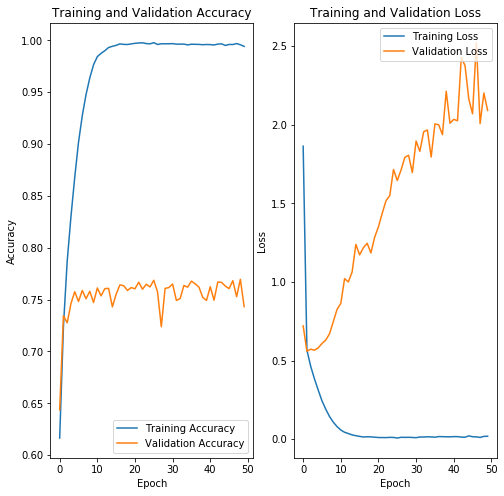

In [80]:
show(historyA)

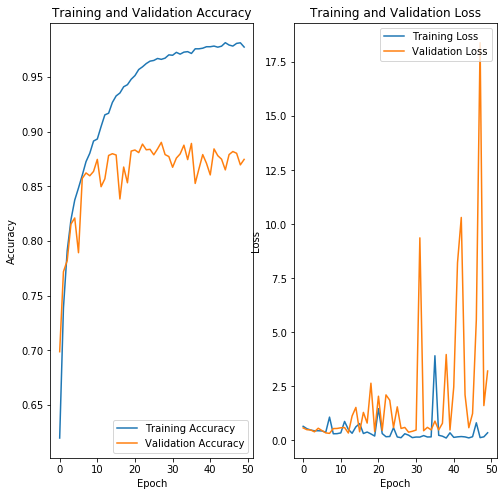

In [81]:
show(historyB)

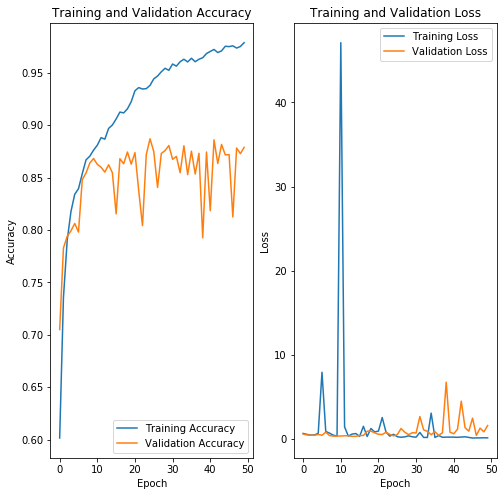

In [82]:
show(historyC)

　訓練回数を50回にした．  
　モデルA，B，Cの訓練正解率は訓練回数とともに直線的に増加しているが，検証正解率は約75%，85%～90%，80～90%に止まっている．損失関数に急激な変化があって，精度が良いモデルではないことが分かった．  
　モデルBとCは，モデルAより大幅に正解率が上がったが，訓練と検証の正解率の差も極めて大きいので，これらのモデルは過学習に陥っていると判断できる． 


# 9.画像判定結果

In [0]:
def result(predictions):
  plt.figure(figsize=(10,10))
  class_names=['cat','dog']
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i], cmap=plt.cm.binary)
    
    if predictions[i, 0] >= 0.5: 
      result = 1
      per = predictions[i,0]
    else:
      result = 0
      per = 1-predictions[i,0]
    
    plt.xlabel('{}({:.2%})'.format(class_names[result],per),color='grey')
    
  plt.show()

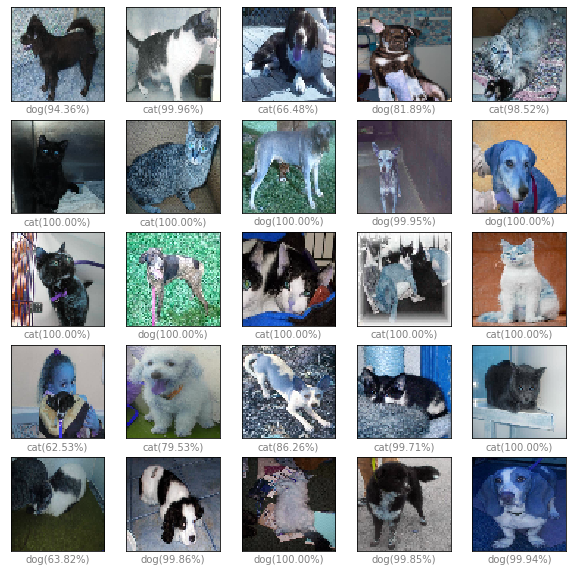

In [142]:
result(predictionsA)

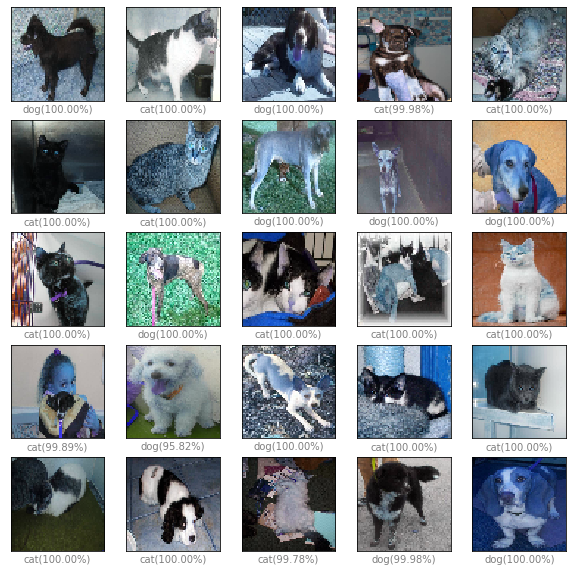

In [143]:
result(predictionsB)

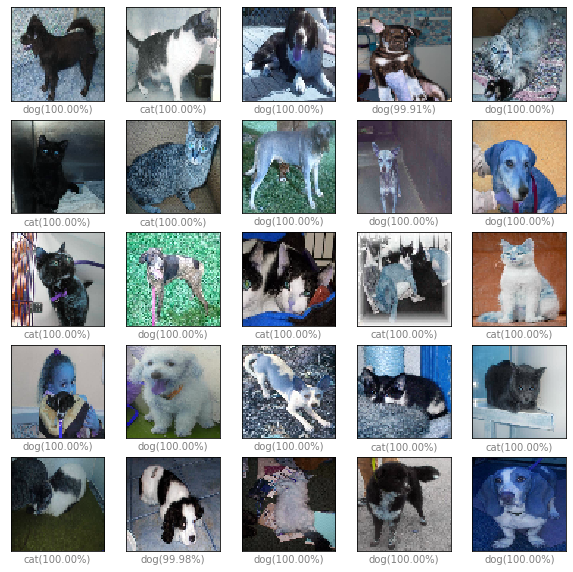

In [144]:
result(predictionsC)

# 10.結果出力

In [0]:
#結果出力
def output(predictions,fileName):
  counter = range(1, len(test)+1)
  solution = pd.DataFrame({"id": counter, "label":list(predictions)})
  cols = ['label']

  for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

  solution.to_csv(fileName+'.csv', index = False)

In [0]:
output(predictionsA,'resultA')
output(predictionsB,'resultB')
output(predictionsC,'resultC')

# 11.画像判定結果（正解付き）

In [0]:
#画像判定結果
def check(model):
  predictions = model.predict(train, verbose=0)

  plt.figure(figsize=(10,10))
  class_names=['cat','dog']

  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap=plt.cm.binary)
    
    if predictions[i, 0] >= 0.5: 
      result = 1
      per = predictions[i,0]
    else:
      result = 0
      per = 1-predictions[i,0]
    
    color='blue'
    if result != labels[i]:
      color = 'red'
    
    plt.xlabel('{}({:.2%})'.format(class_names[result],per),color=color)
    
  plt.show()

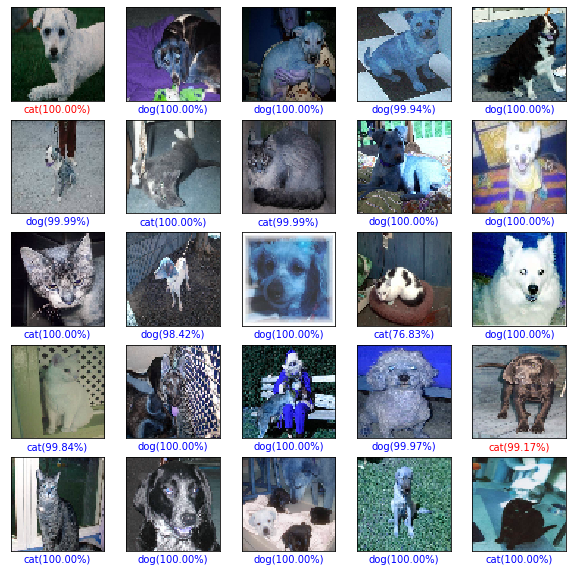

In [130]:
check(modelA)

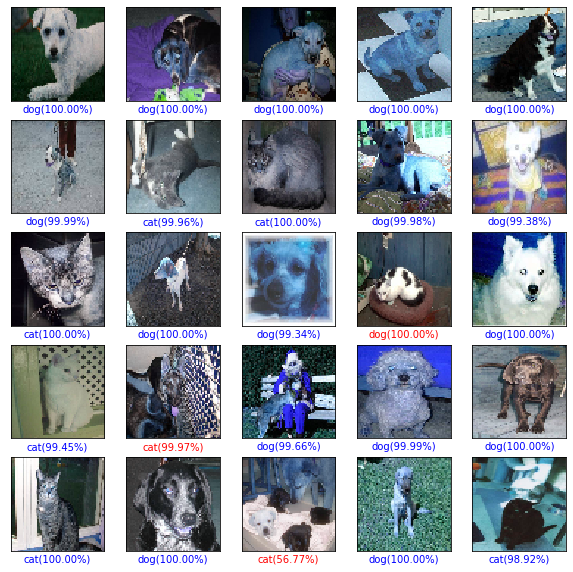

In [131]:
check(modelB)

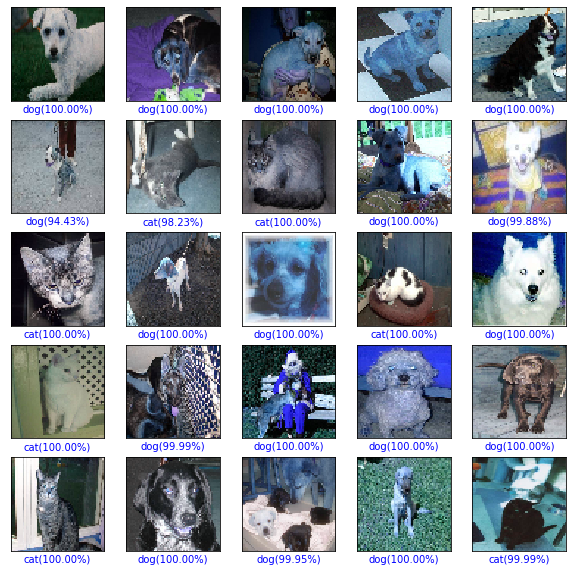

In [133]:
check(modelC)